In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv("data\\solar_stuff\\solar_long.csv", index_col='period_end').ghi
data.index = pd.to_datetime(data.index)
data = data.resample('h').mean()

In [3]:
train_data = data['2017':'2022']
test_data = data['2023':]

In [4]:
train_data = train_data.diff(24).dropna()

In [5]:
train_data

period_end
2018-01-02 00:00:00+00:00    0.0
2018-01-02 01:00:00+00:00    0.0
2018-01-02 02:00:00+00:00    0.0
2018-01-02 03:00:00+00:00    0.0
2018-01-02 04:00:00+00:00    0.0
                            ... 
2022-12-31 19:00:00+00:00    0.0
2022-12-31 20:00:00+00:00    0.0
2022-12-31 21:00:00+00:00    0.0
2022-12-31 22:00:00+00:00    0.0
2022-12-31 23:00:00+00:00    0.0
Freq: h, Name: ghi, Length: 43800, dtype: float64

In [6]:
q1 = train_data.quantile(.25)
q3 = train_data.quantile(.75)
iqr = q3 - q1
train_data[(train_data < q1 - 1.5 * iqr) | (train_data > q3 + 1.5 * iqr)] = np.nan
train_data = train_data.interpolate().dropna()

In [7]:
adfuller(train_data)

(-38.237080744578364,
 0.0,
 24,
 43775,
 {'1%': -3.43049939311256,
  '5%': -2.8616060284807032,
  '10%': -2.5668051448125424},
 61715.44080903956)

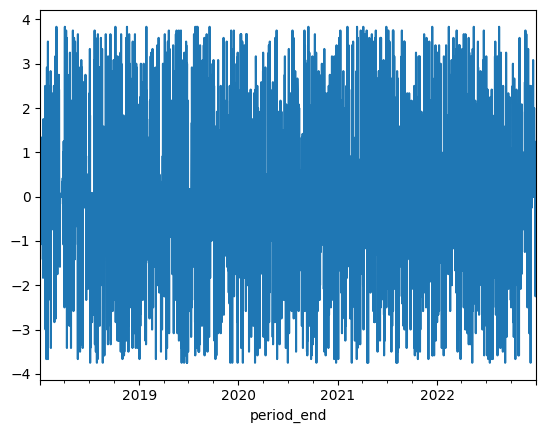

In [8]:
_ = train_data.plot()

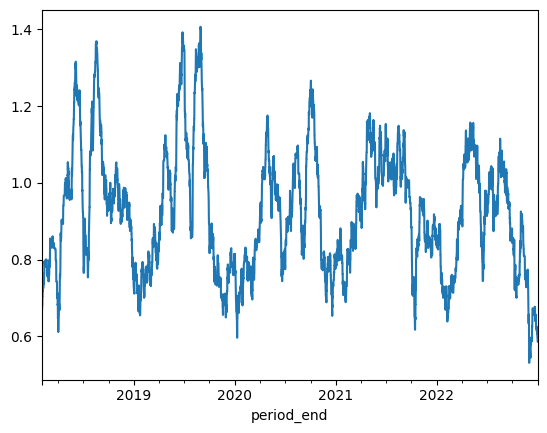

In [9]:
_ = train_data.rolling(24*30).std().dropna().plot()

In [10]:
# model = pmdarima.auto_arima(data,
#                       d=0,
#                       start_p=2, start_q=2, max_d=0,
#                       max_p=6, max_q=6, max_order=12,
#                       trace=True, seasonal=False,
#                       #suppress_warnings=True,
#                       stepwise=True
#                       )
#
# # print model summary
# print(model.summary())

In [11]:
from statsmodels.tsa.arima.model import ARIMA
p, q = 3, 4
model = ARIMA(train_data, order=(p, 0, q)).fit()

In [12]:
residuals = model.resid
parameters = model.params

In [13]:
parameters

const     0.014910
ar.L1     1.114148
ar.L2    -0.073059
ar.L3    -0.159785
ma.L1    -0.217723
ma.L2    -0.132424
ma.L3     0.014653
ma.L4     0.010968
sigma2    0.239849
dtype: float64

In [14]:
from statsmodels.tsa.arima_process import arma_generate_sample
alpha = .1

N = 10000
n = len(test_data)
ar_models = [arma_generate_sample(ar=[1] + list(-parameters[1: 4]), ma=[1] + list(parameters[4: -1]), nsample=n, scale=np.std(residuals)) for _ in range(N)]

In [15]:
ar_models = [pd.Series(ar_model) for ar_model in ar_models]

In [16]:
add = np.zeros(n)
add[:24] = data[:'2022'][-24:]

In [17]:
ar_seasonal_models = [pmdarima.utils.diff_inv(ar_model + add, lag=24) for ar_model in ar_models]
quantiles_lower = np.quantile(ar_seasonal_models, alpha, axis=0)
quantiles_upper = np.quantile(ar_seasonal_models, 1 - alpha, axis=0)
plt.figure(figsize=(12, 5))

# plt.legend([line1, line3], ['przedziały ufności', 'wartości rzeczywiste'])
# plt.xlabel('t')

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

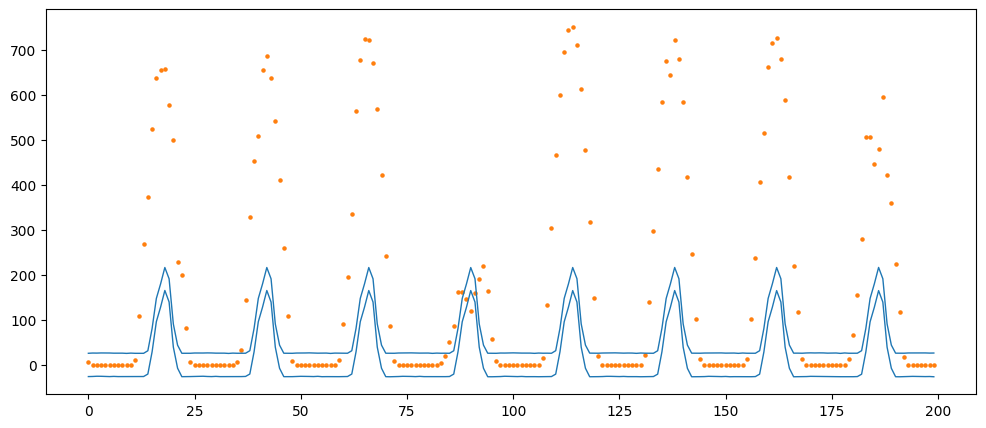

In [20]:
plt.figure(figsize=(12, 5))
quantiles_lower_short = quantiles_lower[-200:]
quantiles_upper_short = quantiles_upper[-200:]
test_data_short = test_data[-200: ]
line1, = plt.plot(range(len(quantiles_lower_short)), quantiles_lower_short, c='C0', linewidth=1)
line2, = plt.plot(range(len(quantiles_upper_short)), quantiles_upper_short, c='C0', linewidth=1)
line3 = plt.scatter(range(len(test_data_short)), test_data_short, s=5, c='C1')